In [2]:
import pandas as pd

def read_nbody_csv(path):
    df = pd.read_csv(path, sep=';')
    df = df.groupby('num_gpus').agg(steps_per_sec=('steps_per_sec', 'median')).reset_index()
    df['step_time_s'] = 1 / df['steps_per_sec']
    seq_steps_per_sec = df.loc[df['num_gpus'] == 1, 'steps_per_sec'].values[0]
    df['speedup'] = df['steps_per_sec'] / seq_steps_per_sec
    df['par_efficiency'] = df['speedup'] / df['num_gpus']
    return df

nbody_idag = read_nbody_csv('leonardo-nbody-float-tiled-1M-100-idag.csv')
nbody_bm = read_nbody_csv('leonardo-nbody-float-tiled-1M-100-legacy-buffer-manager.csv')
nbody_mgpu = read_nbody_csv('leonardo-nbody-float-tiled-1M-100-legacy-ccgrid-multigpu.csv')

In [3]:
def read_rsim_csv(path):
    df = pd.read_csv(path, sep=';')
    df = df.groupby('num_gpus').agg(ms_per_timestep=('ms_per_timestep', 'median')).reset_index()
    df['step_time_s'] = df['ms_per_timestep'] / 1000
    df['steps_per_sec'] = 1 / df['step_time_s']
    seq_steps_per_sec = df.loc[df['num_gpus'] == 1, 'steps_per_sec'].values[0]
    df['speedup'] = df['steps_per_sec'] / seq_steps_per_sec
    df['par_efficiency'] = df['speedup'] / df['num_gpus']
    return df

rsim_idag = read_rsim_csv('leonardo-rsim-rvl-1000-idag.csv')
rsim_bm_naive = read_rsim_csv('leonardo-rsim-rvl-1000-legacy-buffer-manager-naive.csv')
rsim_mgpu_naive = read_rsim_csv('leonardo-rsim-rvl-1000-legacy-ccgrid-multigpu-naive.csv')
rsim_bm_hack = read_rsim_csv('leonardo-rsim-rvl-1000-legacy-buffer-manager-resize-hack.csv')
rsim_mgpu_hack = read_rsim_csv('leonardo-rsim-rvl-1000-legacy-ccgrid-multigpu-resize-hack.csv')

In [4]:
def read_wave_sim_csv(path, n_steps):
    df = pd.read_csv(path, sep=';')
    df = df.groupby('num_gpus').agg(total_ms=('total_ms', 'median')).reset_index()
    df['step_time_s'] = df['total_ms'] / 1000 / n_steps
    df['steps_per_sec'] = 1 / df['step_time_s']
    seq_steps_per_sec = df.loc[df['num_gpus'] == 1, 'steps_per_sec'].values[0]
    df['speedup'] = df['steps_per_sec'] / seq_steps_per_sec
    df['par_efficiency'] = df['speedup'] / df['num_gpus']
    return df

wave_sim_idag = read_wave_sim_csv('leonardo-wavesim-16k-200-idag.csv', 200)
wave_sim_bm = read_wave_sim_csv('leonardo-wavesim-16k-200-legacy-buffer-manager.csv', 200)
wave_sim_mgpu = read_wave_sim_csv('leonardo-wavesim-16k-200-legacy-ccgrid-multigpu.csv', 200)

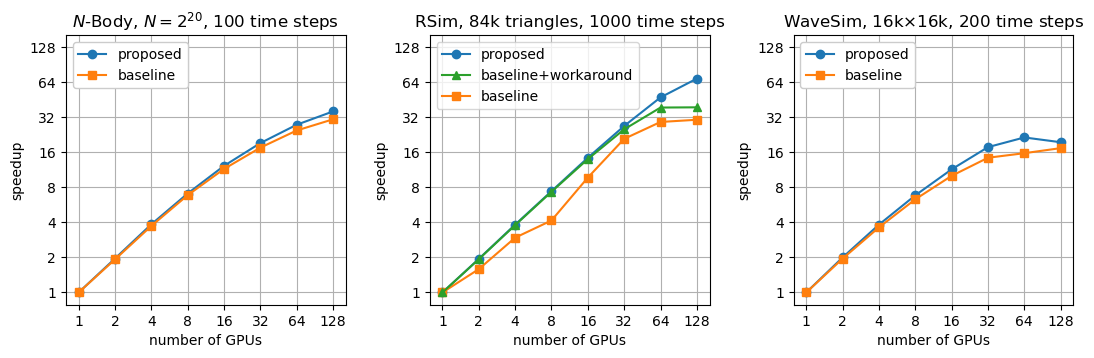

In [9]:
from matplotlib import pyplot as plt
from matplotlib import ticker as mticker

STYLES=['o-', 's-', '^-', 'v-', '<-', '>-', 'x-', 'D-']

def plot_one(ax, dfs_and_labels, title):
    for i, (df, label) in enumerate(dfs_and_labels):
        ax.plot(df['num_gpus'], df['speedup'], STYLES[i], ms=6, label=label)

    POWERS = [2**i for i in range(0, 8)]
    ax.set_xscale('log')
    ax.set_xticks(POWERS)
    ax.get_xaxis().set_major_formatter(mticker.ScalarFormatter())
    ax.set_xlabel('number of GPUs')

    ax.set_yscale('log')
    ax.set_yticks(POWERS)
    ax.get_yaxis().set_major_formatter(mticker.ScalarFormatter())
    ax.set_ylabel('speedup')
    # ax.set_ylabel('parallel efficiency')
    # ax.set_ylim(-0.05, 1.05)
    ax.set_ylim(ax.get_xlim())

    ax.minorticks_off()
    ax.grid(axis='both')

    ax.legend(loc='upper left', framealpha=1)
    ax.set_title(title)

fig, axes = plt.subplots(ncols=3, figsize=(13, 3.5), gridspec_kw={'wspace': 0.3})

plot_one(axes[0], [
        (nbody_idag, 'proposed'),
        (nbody_bm, 'baseline'),
        # (nbody_mgpu, 'mgpu'),
    ], r'$N$-Body, $N=2^{20}$, 100 time steps')

plot_one(axes[1], [
        (rsim_idag, 'proposed'),
        (rsim_bm_naive, 'baseline'),
        (rsim_bm_hack, 'baseline+workaround'),
        # (rsim_mgpu_naive, 'mgpu (naive)'),
        # (rsim_mgpu_hack, 'mgpu (resize hack)'),
    ], r'RSim, 84k triangles, 1000 time steps')

handles, labels = axes[1].get_legend_handles_labels()
handles[1], handles[2] = handles[2], handles[1]
labels[1], labels[2] = labels[2], labels[1]
axes[1].legend(handles, labels)

plot_one(axes[2], [
        (wave_sim_idag, 'proposed'),
        (wave_sim_bm, 'baseline'),
        # (wave_sim_mgpu, 'mgpu'),
    ], r'WaveSim, 16k$\times$16k, 200 time steps')
fig.savefig('strong-scaling.pdf', bbox_inches='tight')
